In [41]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import numpy as np
from dotenv import load_dotenv
import os

## Adatok lematizálása és adatbázisba mentése

In [42]:
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)

df = pd.read_sql("SELECT * FROM articles WHERE lemmatized_text is NULL ", con=engine)


In [43]:
from bs4 import BeautifulSoup

df['summary'] = df['summary'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())

In [44]:
df['text'] = df['title'] + ' ' + df['summary']

In [45]:
df

,id,title,summary,lemmatized_text,link,category,predicted_category,published,text
0,30273,Hatalmasat zuhant a magyar bankok nyeresége: m...,Első ránézésre feltűnően rosszul muzsikált a m...,None,https://www.portfolio.hu/bank/20250605/hatalma...,Bank,None,2025-06-05 11:12:00,Hatalmasat zuhant a magyar bankok nyeresége: m...
1,30274,Palkovics László: hamarosan elfogadhatja a kor...,A 2020-ban elfogadott mesterséges intelligenci...,None,https://www.portfolio.hu/gazdasag/20250605/pal...,Gazdaság,None,2025-06-05 11:01:00,Palkovics László: hamarosan elfogadhatja a kor...
2,30275,Jó hangulatban várják a tőzsdék a nap eseményét,Vegyes irányok és mérsékelt elmozdulások jelle...,None,https://www.portfolio.hu/uzlet/20250605/jo-han...,Üzlet,None,2025-06-05 11:00:00,Jó hangulatban várják a tőzsdék a nap eseményé...
3,30276,Nagy forgalommal emelkedik a Richter,Az európai tőzsdéken enyhén pozitív a hangulat...,None,https://www.portfolio.hu/uzlet/20250605/nagy-f...,Üzlet,None,2025-06-05 11:00:00,Nagy forgalommal emelkedik a Richter Az európa...
4,30277,"„Egy igazi rosszfiú” – Végre kiderült, mit gon...","A The New York Times beszámolt róla, hogy köze...",None,https://www.portfolio.hu/global/20250605/egy-i...,Globál,None,2025-06-05 10:53:00,"„Egy igazi rosszfiú” – Végre kiderült, mit gon..."
...,...,...,...,...,...,...,...,...,...
141,30414,"Hoppá: gyűrűt vett a Tankcsapda dobosa, közele...",Fejes Tamás 130 ezret fizetett a gyönyörűért.,None,https://www.borsonline.hu/magyar-sztarhirek/20...,magyar-sztarhirek,None,2025-06-05 10:20:00,"Hoppá: gyűrűt vett a Tankcsapda dobosa, közele..."
142,30415,"Kőszeg látnivalói – Egy varázslatos város, aho...","Kőszeg látnivalói között a középkori vár, a ha...",None,https://www.borsonline.hu/belfoldi-utazas/2025...,belfoldi-utazas,None,2025-06-05 10:15:00,"Kőszeg látnivalói – Egy varázslatos város, aho..."
143,30416,Szirénázó rendőrautók lepték el Katalin és Vil...,Az elkövetőt hamar elfogták.,None,https://www.borsonline.hu/kiralyi-csalad/2025/...,kiralyi-csalad,None,2025-06-05 10:00:00,Szirénázó rendőrautók lepték el Katalin és Vil...
144,30417,Ezek a világ legszebb strandjai 2025-ben – Az ...,Idén a világ legszebb strandja Európában van –...,None,https://www.borsonline.hu/kulfoldi-utazas/2025...,kulfoldi-utazas,None,2025-06-05 09:45:00,Ezek a világ legszebb strandjai 2025-ben – Az ...


In [46]:
import huspacy
import spacy

huspacy.download()
nlp = spacy.load("hu_core_news_lg")

['C:\\Users\\KomPhone\\projects\\ml\\cubix_ml_vizsga\\.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


In [47]:
def lemmatize(text):
    doc = nlp(text.lower())
    return ' '.join(
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    )

df['lemmatized_text'] = df['text'].apply(lemmatize)


In [48]:
from sqlalchemy.orm import Session
from app.db.database import SessionLocal
import app.models as models

db: Session = SessionLocal()

articles_to_update = (
    db.query(models.Articles)
    .filter(models.Articles.lemmatized_text.is_(None))
    .all()
)

lemmatized_map = dict(zip(df['link'], df['lemmatized_text']))

for article in articles_to_update:
    if article.link in lemmatized_map:
        article.lemmatized_text = lemmatized_map[article.link]

db.commit()
db.close()

## Kategoriák előkészítése

In [49]:
df = pd.read_sql("SELECT * FROM articles", con=engine)

In [50]:
df

,id,title,summary,lemmatized_text,link,category,predicted_category,published
0,1,Satuba fogták a forintot,"Hétfőn egy enyhe erősödéssel zárt a forint, bá...",satu fog forint hétfő enyhe erősödés zár forin...,https://www.portfolio.hu/deviza/20250603/satub...,Deviza,None,2025-06-03 08:30:00
1,2,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,visszadob zelenszkij orosz békefeltétel botrán...,https://www.portfolio.hu/global/20250603/vissz...,Globál,None,2025-06-03 08:25:00
2,3,Nyilatkozott a béketárgyalásokról Oroszország ...,"Telegram fiókján nyilatkozott a tegnapi, siker...",nyilatkozik béketárgyalás oroszország erős emb...,https://www.portfolio.hu/global/20250603/nyila...,Globál,None,2025-06-03 08:25:00
3,4,Sínre tették von der Leyen újabb százmilliárdo...,"Jó úton haladnak afelé, hogy még az év vége el...",sín tesz von der ley százmilliárdos keleti ügy...,https://www.portfolio.hu/unios-forrasok/202506...,Uniós források,None,2025-06-03 08:22:00
4,5,Itt a friss előrejelzés: idén alig növekedhet ...,Az OECD friss előrejelzése szerint a magyar ga...,friss előrejelzés idén alig növekedhet magyar ...,https://www.portfolio.hu/gazdasag/20250603/itt...,Gazdaság,None,2025-06-03 08:09:00
...,...,...,...,...,...,...,...,...
30413,30414,"Hoppá: gyűrűt vett a Tankcsapda dobosa, közele...",Fejes Tamás 130 ezret fizetett a gyönyörűért.,hoppá gyűrű vesz tankcsapda dobos közeleg elje...,https://www.borsonline.hu/magyar-sztarhirek/20...,magyar-sztarhirek,None,2025-06-05 10:20:00
30414,30415,"Kőszeg látnivalói – Egy varázslatos város, aho...","Kőszeg látnivalói között a középkori vár, a ha...",kőszeg látnivaló varázslatos város ahova érdem...,https://www.borsonline.hu/belfoldi-utazas/2025...,belfoldi-utazas,None,2025-06-05 10:15:00
30415,30416,Szirénázó rendőrautók lepték el Katalin és Vil...,Az elkövetőt hamar elfogták.,szirénázó rendőrautó lep katalin vilmos herceg...,https://www.borsonline.hu/kiralyi-csalad/2025/...,kiralyi-csalad,None,2025-06-05 10:00:00
30416,30417,Ezek a világ legszebb strandjai 2025-ben – Az ...,Idén a világ legszebb strandja Európában van –...,világ szép strand első hely európai strand vég...,https://www.borsonline.hu/kulfoldi-utazas/2025...,kulfoldi-utazas,None,2025-06-05 09:45:00


In [51]:
df.drop([
    "id",
    "predicted_category",
    "published",
    "link"
], axis=1, inplace=True)

In [52]:
import unicodedata

def remove_accents(text):
    if isinstance(text, str):
        nfkd_form = unicodedata.normalize('NFKD', text)
        return ''.join([c for c in nfkd_form if not unicodedata.combining(c)]).lower()
    return text

df['category'] = df['category'].apply(remove_accents)

In [53]:
df.dropna(inplace=True)

### Kategoriák összevonása

In [54]:
df['category'] = df['category'].replace({
    'global': 'kulfold',
    'hirtvkulfold': 'kulfold',
    'kulpol': 'kulfold',
    'nagyvilag': 'kulfold',
    'vilag': 'kulfold',
    'celeb': 'bulvar',
    'sztarok': 'bulvar',
    'sztarvilag': 'bulvar',
    'kultur': 'kultura',
    'teve': 'bulvar',
    'techtud': 'tudomany',
    'techbazis': 'tudomany',
    'tech-tudomany': 'tudomany',
    'tech': 'tudomany',
    'itthon': 'belfold',
    'belpol': 'belfold',
    'politika': 'belfold',
    'nemzetkozi-gazdasag': 'gazdasag',
    'uzlet': 'gazdasag',
    'penz': 'gazdasag',
    'bank': 'gazdasag',
    'befektetes': 'gazdasag',
    'deviza': 'gazdasag',
    'vilaggazdasag-magyar-gazdasag': 'gazdasag',
    'elet-stilus': 'eletmod',
    'ferfiaknak': 'eletmod',
    'test-es-lelek': 'eletmod',
    'bunugyek': 'baleset-bunugy',
    'futball': 'sport',
    'foci': 'sport',
    'szorakozas': 'bulvar',
})

### Kategoriák eltávolítása
Értelmetlen valós információt nem tartalmazó kategoriák letávolítása

In [55]:
df = df[~df['category'].isin(['2023', 'hirek', 'hirado', 'aktualis', 'mindekozben'])]

Kategoriák szűrése

In [56]:
category_counts = df['category'].value_counts()

valid_categories = category_counts[category_counts >= 300].index

df = df[df['category'].isin(valid_categories)]


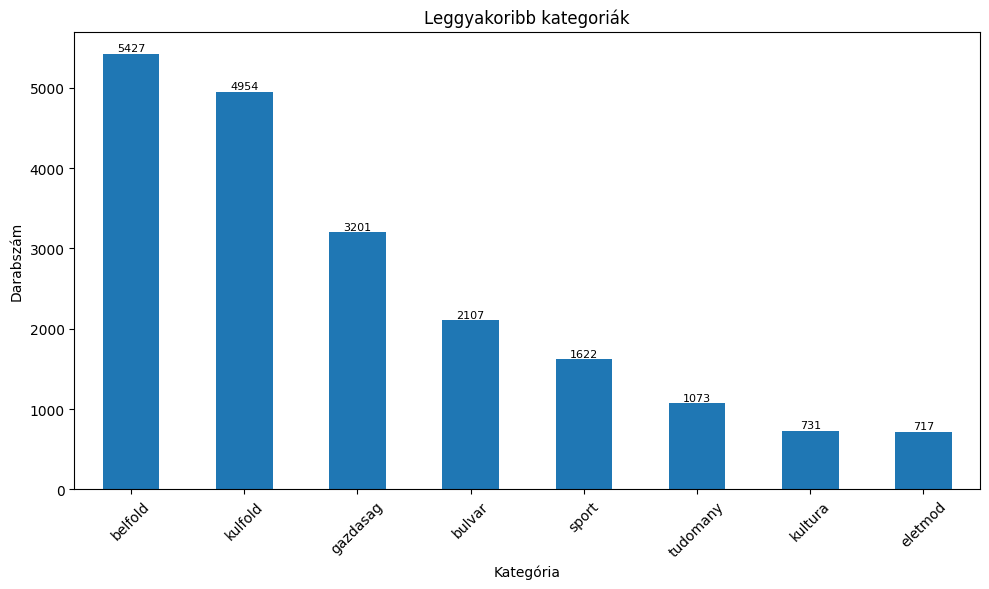

In [57]:
import matplotlib.pyplot as plt

top_categories = df['category'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
ax = top_categories.plot(kind='bar')

plt.title('Leggyakoribb kategoriák')
plt.xlabel('Kategória')
plt.ylabel('Darabszám')
plt.xticks(rotation=45)
plt.tight_layout()

for i, value in enumerate(top_categories.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.show()

In [58]:
df

,title,summary,lemmatized_text,category
0,Satuba fogták a forintot,"Hétfőn egy enyhe erősödéssel zárt a forint, bá...",satu fog forint hétfő enyhe erősödés zár forin...,gazdasag
1,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,visszadob zelenszkij orosz békefeltétel botrán...,kulfold
2,Nyilatkozott a béketárgyalásokról Oroszország ...,"Telegram fiókján nyilatkozott a tegnapi, siker...",nyilatkozik béketárgyalás oroszország erős emb...,kulfold
4,Itt a friss előrejelzés: idén alig növekedhet ...,Az OECD friss előrejelzése szerint a magyar ga...,friss előrejelzés idén alig növekedhet magyar ...,gazdasag
5,Megnevezték az oroszok a bombázóflottát megbén...,Egy Artyom Timofejev nevű ukrán férfit gyanúsí...,megnevez orosz bombázóflotta megbénító támadás...,kulfold
...,...,...,...,...
30399,Mi történt a honvédelmi és rendészeti bizottsá...,Kósa Lajos országgyűlési képviselő június 5-re...,történik honvédelmi rendészeti bizottság rendk...,belfold
30400,„Aláírtam” – Orbán Viktor rejtélyes közleménny...,Orbán Viktor miniszterelnök csütörtökön bejele...,aláír orbán viktor rejtélyes közlemény jelentk...,belfold
30401,Mindenkit lemészárol a John Wick-széria Baleri...,A John Wick széria az utóbbi évek során az akc...,mindenki lemészárol john baleriná női főszerep...,bulvar
30404,Eltűnt a képernyőről Erős Antónia! Most kiderü...,Napok óta nem láthatták a nézők Erős Antóniát ...,eltűnik képernyő erős antónia kiderül látható ...,bulvar


## Kategoria predikció XGBoost-tel

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
df['combined'] = df['summary'] + ' ' + df['lemmatized_text']
X = vectorizer.fit_transform(df['combined'])

In [60]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])


In [61]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weight_dict = dict(zip(classes, class_weights))

# Minden sorhoz hozzárendeljük a megfelelő súlyt
sample_weights = np.array([weight_dict[label] for label in y])


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)


In [63]:
import optuna
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10)
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


In [64]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # 10


[I 2025-06-05 13:18:48,918] A new study created in memory with name: no-name-5f54fb0a-a67d-455f-b96d-1a03567553ba
[I 2025-06-05 13:19:29,297] Trial 0 finished with value: 0.6691419302389633 and parameters: {'n_estimators': 470, 'max_depth': 5, 'learning_rate': 0.2229857374666386, 'subsample': 0.8409858393217391, 'colsample_bytree': 0.894378413140179, 'gamma': 6}. Best is trial 0 with value: 0.6691419302389633.
[I 2025-06-05 13:20:03,259] Trial 1 finished with value: 0.6571100513786537 and parameters: {'n_estimators': 395, 'max_depth': 9, 'learning_rate': 0.17836583239624695, 'subsample': 0.9749818990470858, 'colsample_bytree': 0.9349671503180793, 'gamma': 9}. Best is trial 0 with value: 0.6691419302389633.
[I 2025-06-05 13:21:36,068] Trial 2 finished with value: 0.6890114747345218 and parameters: {'n_estimators': 486, 'max_depth': 5, 'learning_rate': 0.0562536435009605, 'subsample': 0.9782403384529921, 'colsample_bytree': 0.9234679338663868, 'gamma': 0}. Best is trial 2 with value: 0.6

In [65]:
# study.stop()

In [66]:
print("Best trial:")
print("  Value (macro F1):", study.best_value)
print("  Params:", study.best_params)

Best trial:
  Value (macro F1): 0.6911132531636626
  Params: {'n_estimators': 301, 'max_depth': 9, 'learning_rate': 0.24033105011399966, 'subsample': 0.8219754756042266, 'colsample_bytree': 0.9863041453317289, 'gamma': 3}


In [67]:
best_model = XGBClassifier(
    **study.best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    n_jobs=-1
)

best_model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9863041453317289, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.24033105011399966,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=301, n_jobs=-1, num_class=8, ...)

In [68]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     belfold       0.72      0.71      0.71      1086
      bulvar       0.73      0.77      0.75       422
     eletmod       0.59      0.62      0.60       143
    gazdasag       0.71      0.71      0.71       640
     kulfold       0.80      0.74      0.77       991
     kultura       0.52      0.61      0.56       146
       sport       0.88      0.86      0.87       324
    tudomany       0.49      0.62      0.55       215

    accuracy                           0.72      3967
   macro avg       0.68      0.70      0.69      3967
weighted avg       0.73      0.72      0.73      3967



In [69]:
import joblib
joblib.dump(best_model, "xgboost_best_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [70]:
def predict_category(text: str) -> str:
    text_clean = (lemmatize(text)).lower()
    X = vectorizer.transform([text_clean])
    pred = best_model.predict(X)
    return le.inverse_transform(pred)[0]


In [71]:
predict_category('A női energia aktiválása! 4 gyakorlat, hogy újra kapcsolódj a feminin énedhez')

'sport'

## Kategória predikció Neurális hálóval-val

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['combined'])

le = LabelEncoder()
y = le.fit_transform(df['category'])
y_cat = to_categorical(y)

# 3. Tanító és teszt halmaz
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, stratify=y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# 4. Súlyozás a kiegyensúlyozatlan osztályokhoz
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = dict(enumerate(class_weights))

# 5. Neurális háló modell
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# 6. Tanítás
model.fit(
    X_train.toarray(), y_train,
    validation_data=(X_val.toarray(), y_val),
    epochs=10,
    batch_size=64,
    class_weight=weight_dict,
    callbacks=[early_stop]
)

# 7. Értékelés
loss, acc = model.evaluate(X_test.toarray(), y_test)
print(f"Pontosság: {acc:.3f}")

Epoch 1/10
217/217 [==============================] - 2s 7ms/step - loss: 1.7273 - accuracy: 0.4618 - val_loss: 1.0359 - val_accuracy: 0.7190
Epoch 2/10
217/217 [==============================] - 1s 6ms/step - loss: 0.8526 - accuracy: 0.7536 - val_loss: 0.7653 - val_accuracy: 0.7523
Epoch 3/10
217/217 [==============================] - 1s 6ms/step - loss: 0.5228 - accuracy: 0.8293 - val_loss: 0.7447 - val_accuracy: 0.7546
Epoch 4/10
217/217 [==============================] - 1s 5ms/step - loss: 0.3535 - accuracy: 0.8753 - val_loss: 0.7553 - val_accuracy: 0.7539
Epoch 5/10
217/217 [==============================] - 1s 5ms/step - loss: 0.2603 - accuracy: 0.9046 - val_loss: 0.7873 - val_accuracy: 0.7469
Epoch 6/10
217/217 [==============================] - 1s 5ms/step - loss: 0.1964 - accuracy: 0.9287 - val_loss: 0.8331 - val_accuracy: 0.7472
Epoch 7/10
93/93 [==============================] - 0s 1ms/step - loss: 0.7429 - accuracy: 0.7607
Pontosság: 0.761


In [73]:
import pickle
model.save("models/category_predicter.keras")

# 2. A TF-IDF vectorizer mentése
with open("models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


## Tesztelés

In [74]:
from tensorflow.keras.models import load_model

model = load_model("models/category_predicter.keras")

with open("models/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)
with open("models/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)


In [75]:
tester = pd.read_sql("SELECT * FROM articles WHERE lemmatized_text is NULL ", con=engine)

In [76]:
tester["text"] = tester["title"].fillna("") + " " + tester["summary"].fillna("")
tester['lemmatized_text'] = tester['text'].apply(lemmatize)

tester["combined"] = tester["text"] + " " + tester['lemmatized_text']
X_new = vectorizer.transform(tester["combined"])

ValueError: Found array with 0 sample(s) (shape=(0, 10000)) while a minimum of 1 is required by TfidfTransformer.

In [39]:
y_pred = model.predict(X_new.toarray())
y_labels = np.argmax(y_pred, axis=1)
tester["predicted_category"] = le.inverse_transform(y_labels)

1/1 [==============================] - 0s 42ms/step


In [40]:
tester

,id,title,summary,lemmatized_text,link,category,predicted_category,published,text,combined
0,30254,Nem csökken a fenyegetés: 60 ezer embert szólí...,Boris Pistorius német védelmi miniszter csütör...,csökken fenyegetés ezer ember szólít fegyver n...,https://www.portfolio.hu/global/20250605/nem-c...,Globál,kulfold,2025-06-05 09:29:00,Nem csökken a fenyegetés: 60 ezer embert szólí...,Nem csökken a fenyegetés: 60 ezer embert szólí...
1,30255,"Friss kutatásból derül ki, hogy állnak a magya...",A magyar lakosság leginkább a megújuló energia...,friss kutatás derül áll magyar megújuló energi...,https://www.portfolio.hu/uzlet/20250605/friss-...,Üzlet,gazdasag,2025-06-05 09:27:00,"Friss kutatásból derül ki, hogy állnak a magya...","Friss kutatásból derül ki, hogy állnak a magya..."
2,30256,Nagyobb veszélyben vannak a rákos beteg férfia...,Az Y-kromoszóma elvesztése csökkenti gyógyulás...,veszély rákos beteg férfi gondol elvesztés csö...,https://index.hu/tudomany/2025/06/05/y-kromosz...,Tudomány,gazdasag,2025-06-05 09:33:00,Nagyobb veszélyben vannak a rákos beteg férfia...,Nagyobb veszélyben vannak a rákos beteg férfia...
3,30257,"Újabb nyolc Apple termékkel szakít a YouTube, ...","Nem csak iPhone-ok, hanem iPadek és még egy iP...",nyolc apple termék szakít youtube csupán megol...,https://index.hu/techtud/2025/06/05/youtube-ip...,Tech-tudomány,eletmod,2025-06-05 09:26:00,"Újabb nyolc Apple termékkel szakít a YouTube, ...","Újabb nyolc Apple termékkel szakít a YouTube, ..."
4,30258,Adósrabszolgaság veszélyére figyelmeztette az ...,"Úgy látja, ha így folytatódik „csak a kamatfiz...",adósrabszolgaság veszély figyelmeztet egyesült...,https://index.hu/kulfold/2025/06/05/elon-musk-...,Külföld,gazdasag,2025-06-05 09:26:00,Adósrabszolgaság veszélyére figyelmeztette az ...,Adósrabszolgaság veszélyére figyelmeztette az ...
5,30259,"Marco Rossi óriási kockázatot vállalt, ha nem ...",A magyar válogatott történetében új fejezetet ...,marco rossi óriási kockázat vállal jön döntés ...,https://index.hu/sport/futball/2025/06/05/magy...,Futball,sport,2025-06-05 09:25:00,"Marco Rossi óriási kockázatot vállalt, ha nem ...","Marco Rossi óriási kockázatot vállalt, ha nem ..."
6,30260,Visszatér Magyarországra az elektronikus zene ...,,visszatér magyarország elektronikus zene franc...,https://index.hu/mindekozben/poszt/2025/06/05/...,Mindeközben,kultura,2025-06-05 09:05:13,Visszatér Magyarországra az elektronikus zene ...,Visszatér Magyarországra az elektronikus zene ...
7,30261,Sopronban indul a boldogság éve,"Június 1-jén nyitotta meg kapuit a SopronFest,...",sopron indul boldogság év június nyit kapu sop...,https://mandiner.hu/kultura/2025/06/sopronban-...,kultura,kultura,2025-06-05 09:30:50,Sopronban indul a boldogság éve Június 1-jén n...,Sopronban indul a boldogság éve Június 1-jén n...
8,30262,A románok idáig jutottak: most már Magyarorszá...,A tények azonban mást mutatnak.,román idáig jut magyarország okol parajdi kata...,https://mandiner.hu/kulfold/2025/06/a-romanok-...,kulfold,gazdasag,2025-06-05 09:25:11,A románok idáig jutottak: most már Magyarorszá...,A románok idáig jutottak: most már Magyarorszá...
9,30263,"Menekülnek a Wizz Air befektetői, értéke negye...","Jelentett a légitáraság, megindult a részvénye...",menekül wizz air befektetői érték negyed veszí...,https://24.hu/fn/gazdasag/2025/06/05/wizz-air-...,Gazdaság,gazdasag,2025-06-05 09:28:50,"Menekülnek a Wizz Air befektetői, értéke negye...","Menekülnek a Wizz Air befektetői, értéke negye..."
